In [1]:
# Set to false if working on local env
onColab = True

model_path = './inno_training_smooth_5'

# Decide batch size and validation split
batch_size = 16
validation_split = 0.2
test_split = 0.01
epochs = 200

dataset_path = './Training_smooth4.csv'

window = 600
stride = 10
# 864 / 8
telescope = 108

In [2]:
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE2
  !ls

Mounted at /gdrive
/gdrive/MyDrive/University/ANN/CHALLENGE2
 3_7424			       inno_training_smooth_4
'3_7424 - drop'		       inno_training_smooth_4_tel144
 aaa			       model.png
'att e1d1'		       multimodel_2
 attmodel		       multi_model_2.ipynb
 attmodel0		       sets
'attmodel bigger'	       smooth11
 baseline		       smooth15
 baseline_ckpt		       smooth21
'baseline copy.ipynb'	       smooth7
 baseline.ipynb		       test2
'div smooth senza lrr_ckpt'    test2_ckpt
'div smooth senza lrr.ipynb'   test2.ipynb
 e1d1_tel288_div	       test4.ipynb
 e1d1_tel288_div.ipynb	       test5.ipynb
 e2d2_div		       Training.csv
 e2d2_div_5stride	       Training_smooth4.csv
 e2d2_div.ipynb		       withoutlrr
 e2d2_tel288		       withoutlrr_ckpt
 e2d2_tel288.ipynb


In [3]:
#@title Import libraries
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [4]:
#@title init seed everywhere
seed =20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
dataset  = pd.read_csv(dataset_path)
print(dataset.shape)
dataset.head()

(68480, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,5.484983,5.713692,8.924425,2.845270,3.602428,31.723626,4.450450
1,5.485001,5.713655,8.924425,2.845263,3.602416,31.723948,4.450430
2,5.485237,5.713199,8.924437,2.845175,3.602270,31.727915,4.450184
3,5.486135,5.711522,8.924551,2.844837,3.601726,31.742346,4.449323
4,5.488279,5.707682,8.924995,2.844031,3.600466,31.775062,4.447453


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68480 entries, 0 to 68479
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68480 non-null  float64
 1   Wonder level        68480 non-null  float64
 2   Crunchiness         68480 non-null  float64
 3   Loudness on impact  68480 non-null  float64
 4   Meme creativity     68480 non-null  float64
 5   Soap slipperiness   68480 non-null  float64
 6   Hype root           68480 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


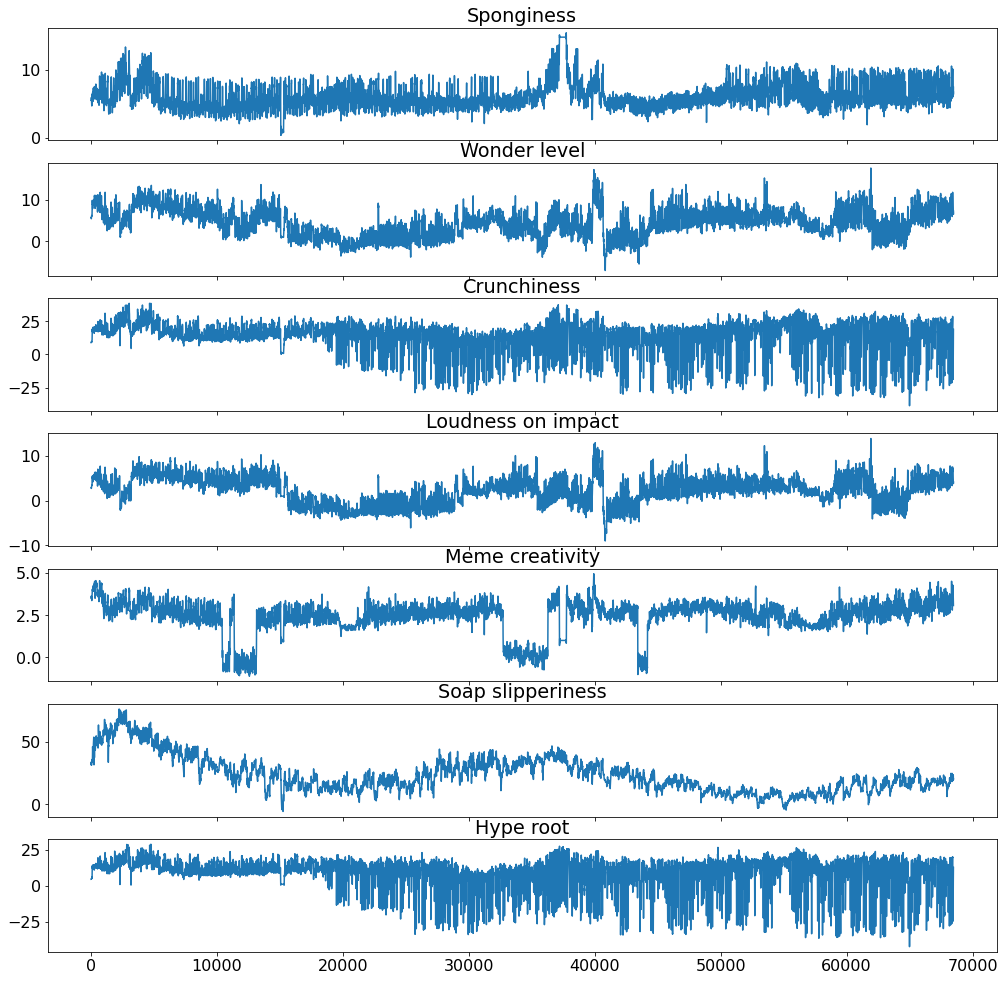

In [7]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

In [8]:
test_size = round(dataset.shape[0] * test_split)
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_noNorm = X_train_raw
X_test_noNorm = X_test_raw

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)


(67795, 7) (685, 7)


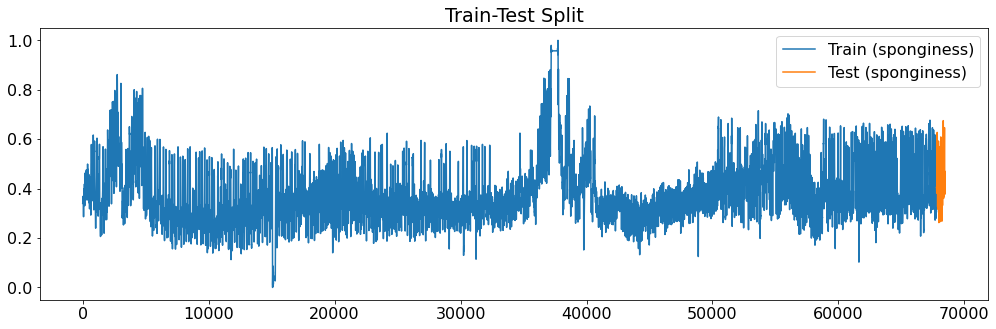

In [9]:
plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [10]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 600, 7)

In [11]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [12]:
target_labels = dataset.columns

In [13]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6710, 600, 7), (6710, 108, 7), (50, 600, 7), (50, 108, 7))

In [14]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [15]:
X_train.shape

(6710, 600, 7)

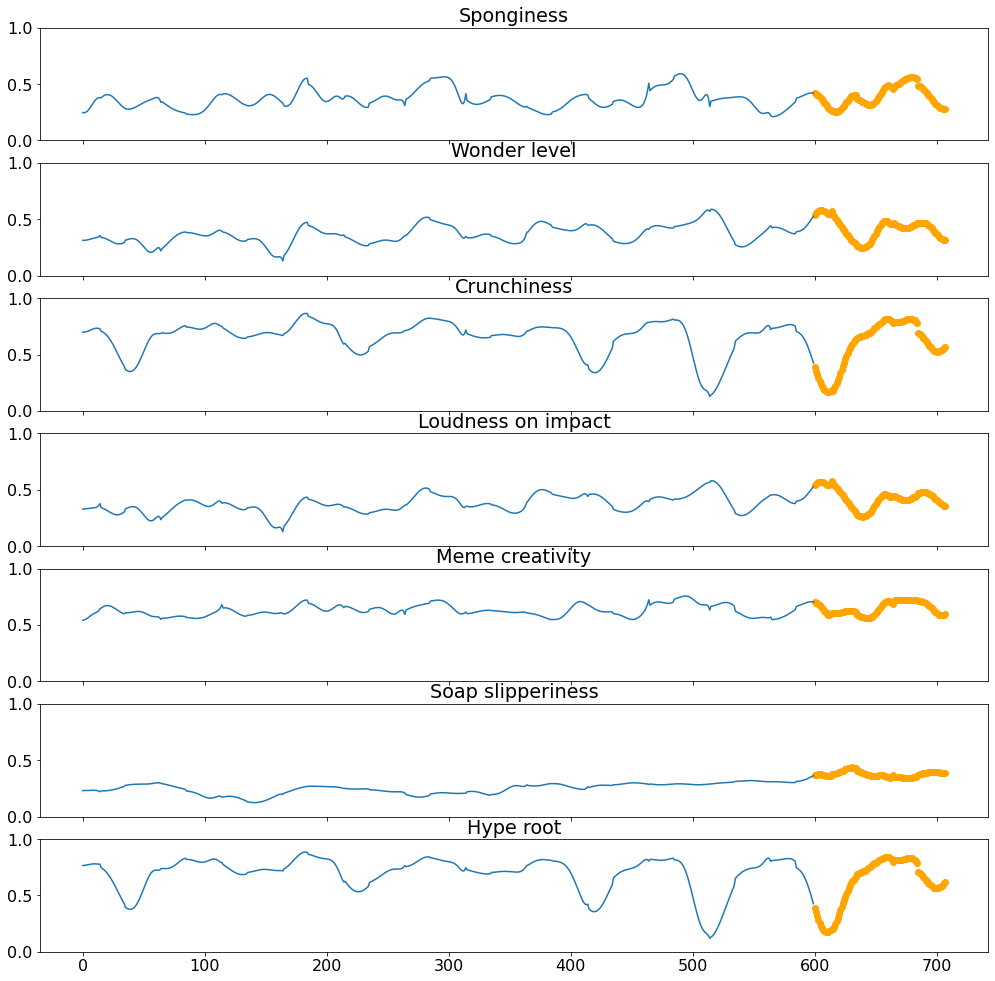

In [16]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [17]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
input_shape, output_shape

((600, 7), (108, 7))

In [18]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    n_features = input_shape[1]
    n_past = input_shape[0]
    n_future = output_shape[0]

    #
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))    
    encoder_l1 = tf.keras.layers.LSTM(256, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)

    encoder_states1 = encoder_outputs1[1:]

    #
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

    #
    decoder_l1 = tf.keras.layers.LSTM(256, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

    #
    model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

    model_e1d1.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    return model_e1d1

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 7)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        270336      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 108, 256)     0           ['lstm[0][0]']                   
                                                                                              

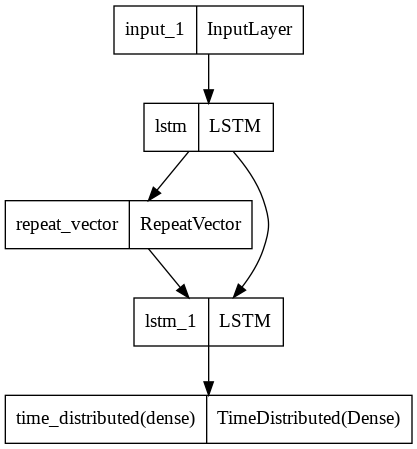

In [19]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [20]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = validation_split,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5),
        # tfk.callbacks.ModelCheckpoint(model_path + '_ckpt', save_best_only=True)
    ]
).history

Epoch 1/200
336/336 [==============================] - 19s 37ms/step - loss: 0.0136 - mae: 0.0812 - val_loss: 0.0155 - val_mae: 0.0891 - lr: 0.0010
Epoch 2/200
336/336 [==============================] - 12s 35ms/step - loss: 0.0098 - mae: 0.0708 - val_loss: 0.0153 - val_mae: 0.0882 - lr: 0.0010
Epoch 3/200
336/336 [==============================] - 12s 35ms/step - loss: 0.0093 - mae: 0.0686 - val_loss: 0.0142 - val_mae: 0.0831 - lr: 0.0010
Epoch 4/200
336/336 [==============================] - 12s 35ms/step - loss: 0.0094 - mae: 0.0693 - val_loss: 0.0147 - val_mae: 0.0829 - lr: 0.0010
Epoch 5/200
336/336 [==============================] - 12s 34ms/step - loss: 0.0091 - mae: 0.0677 - val_loss: 0.0139 - val_mae: 0.0796 - lr: 0.0010
Epoch 6/200
336/336 [==============================] - 12s 35ms/step - loss: 0.0075 - mae: 0.0621 - val_loss: 0.0099 - val_mae: 0.0693 - lr: 0.0010
Epoch 7/200
336/336 [==============================] - 12s 35ms/step - loss: 0.0058 - mae: 0.0548 - val_loss: 0.

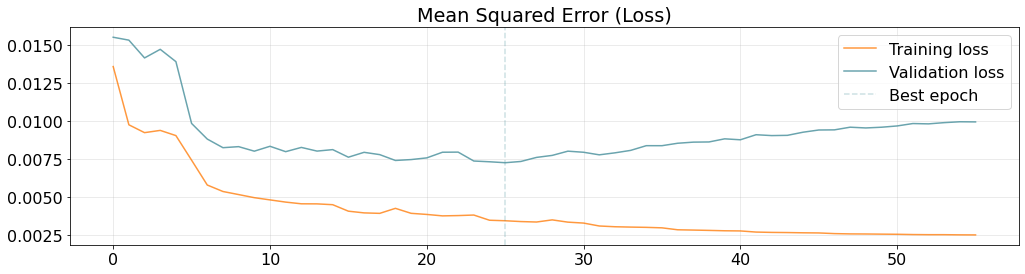

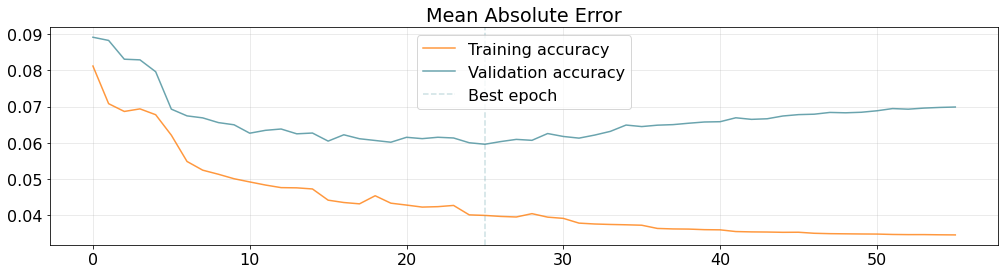

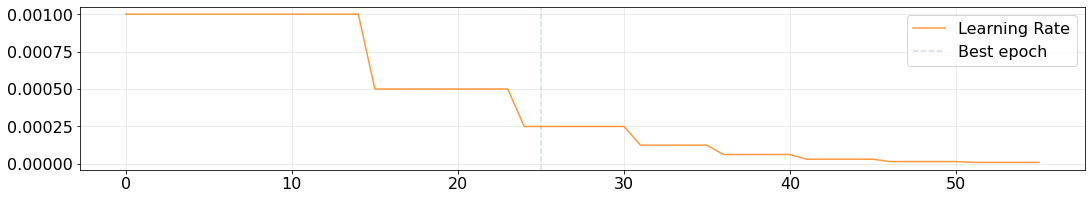

In [21]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [22]:
model.save(model_path)

In [23]:
model = tfk.models.load_model(model_path)

In [24]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(50, 108, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.006355125>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.055744734>)

In [25]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

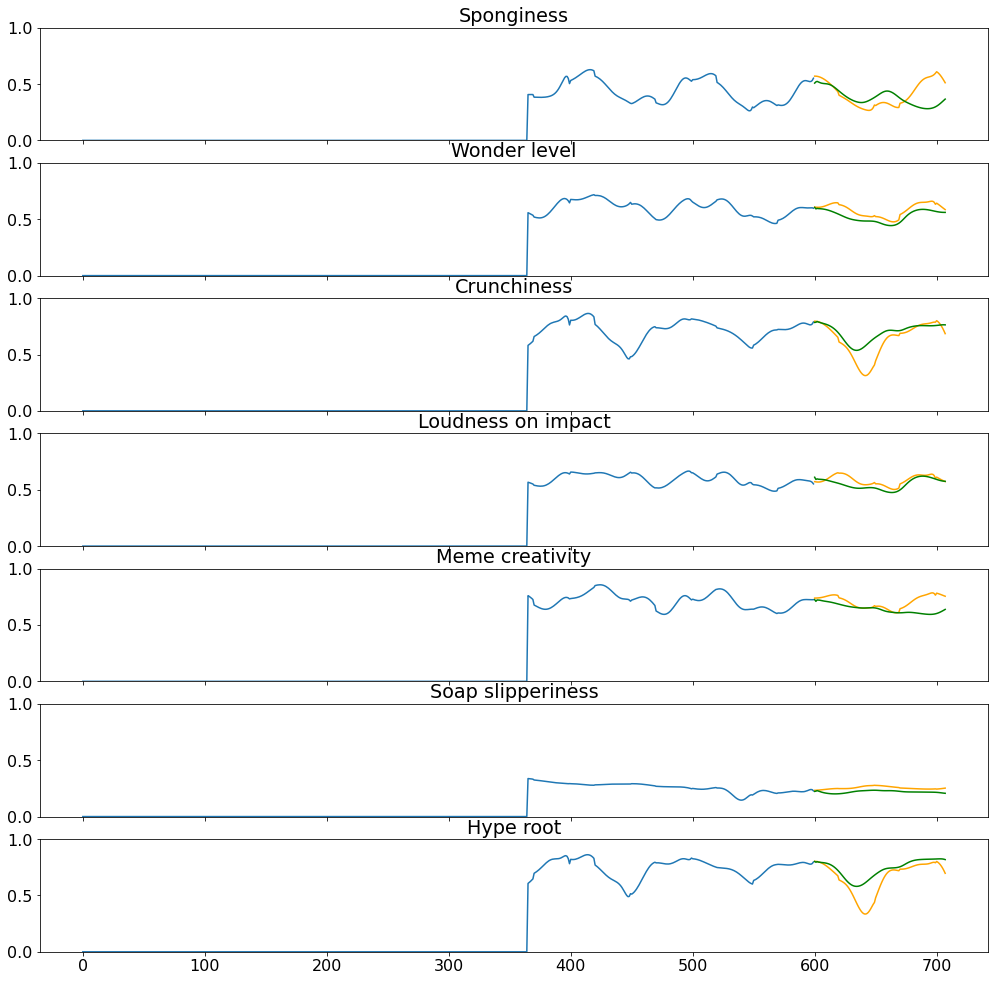

In [26]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [27]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [28]:
future_predictions = model.predict(future)

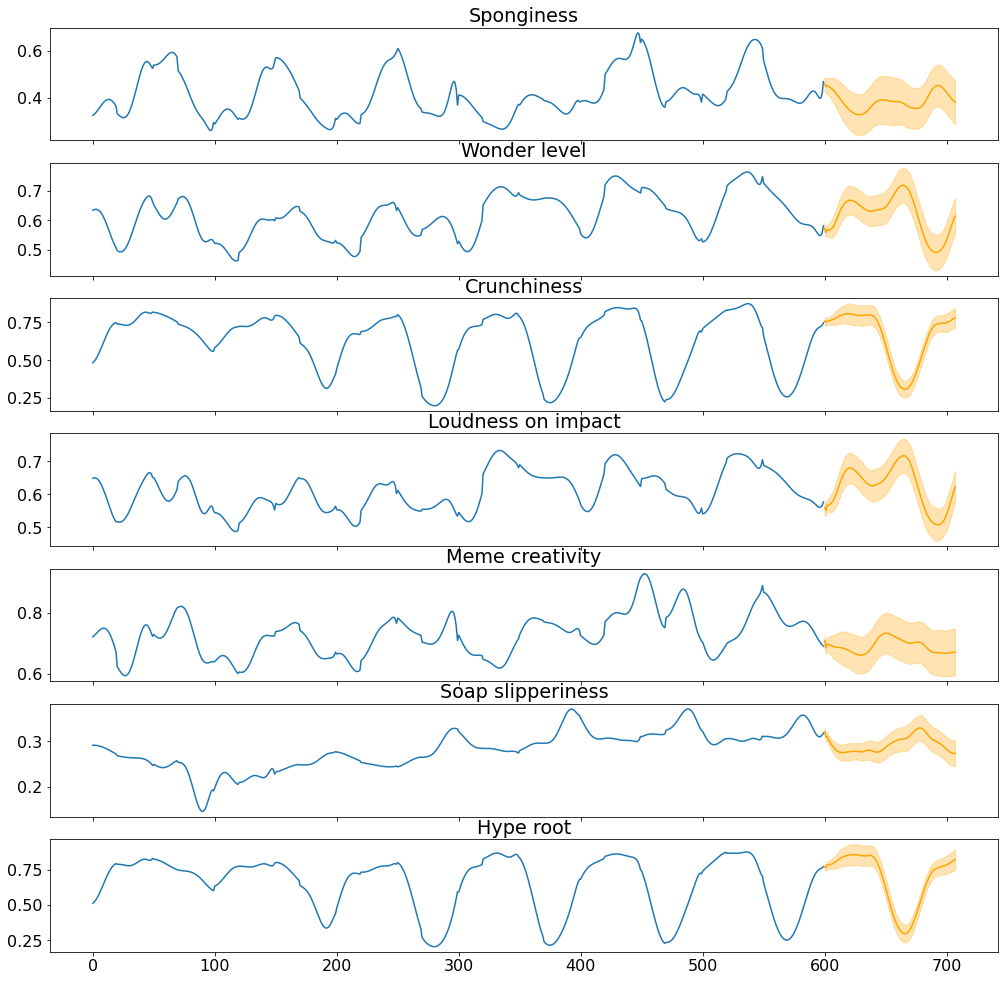

In [29]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

In [30]:
reg_telescope = 216
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((39, 600, 7), (39, 216, 7))

In [31]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [32]:
reg_predictions.shape

(39, 216, 7)

In [33]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.007941468>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.06489103>)

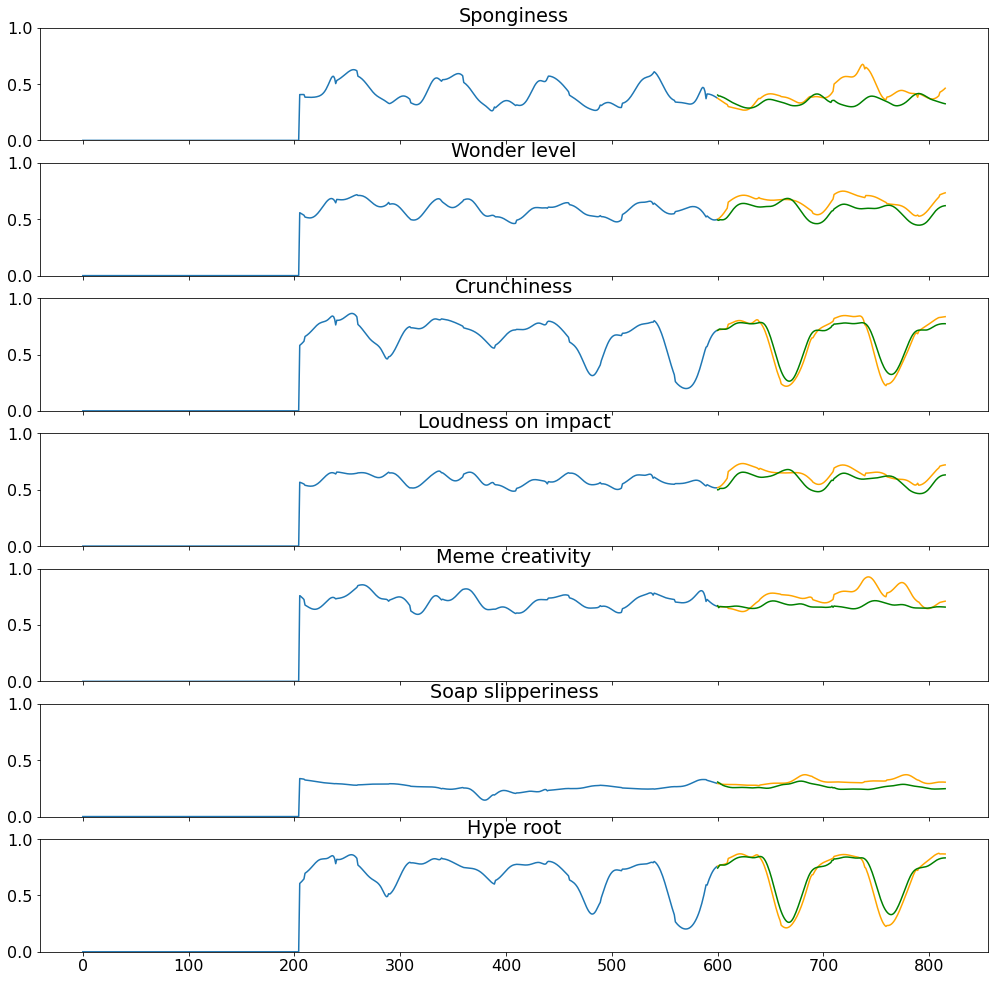

In [34]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)